In [ ]:
# проверим выделенные для ноутбука ресурсы
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install -q gputil
!pip install -q psutil
!pip install -q humanize
import psutil as ps # library for retrieving information on running processes and system utilization
import humanize as hm # library for turning a number into a fuzzy human-readable
import os # library for operations with operation system 
import GPUtil as GPU # access to GPU subsystem
GPUs = GPU.getGPUs() # get number of GPUs
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
process = ps.Process(os.getpid())
print(f'Gen RAM Free: {hm.naturalsize( ps.virtual_memory().available )} | Proc size: {hm.naturalsize( process.memory_info().rss )}')
print( 'GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util: {2:3.0f}% | Total: {3:.0f}MB'.format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
print(f'GPU Model: {gpu.name}')

Gen RAM Free: 12.6 GB | Proc size: 95.3 MB
GPU RAM Free: 16280MB | Used: 0MB | Util:   0% | Total: 16280MB
GPU Model: Tesla P100-PCIE-16GB


In [ ]:
# импорт библиотек
import tensorflow as tf # библиотека тензорфлоу
from tensorflow.keras.applications import VGG16 # Pretrained models
from tensorflow.keras.applications import vgg16 # vgg16.preprocess_input for preprocessing image for the model
from tensorflow.keras.models import Model, load_model # модели керас
from tensorflow.keras.layers import Input, Conv2DTranspose, UpSampling2D, concatenate, Activation, Conv2D, MaxPooling2D, BatchNormalization, Maximum, Add, LeakyReLU, Dropout # слои
from tensorflow.compat.v1.keras.preprocessing.image import ImageDataGenerator # генератор для аугментации данных
from tensorflow.keras import backend as K # модуль backend кераса
from tensorflow.keras.optimizers import Adam # оптимайзеры 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau # колбэки
from tensorflow.keras import utils # утилиты кераса для OHE
from tensorflow.keras.preprocessing import image # работа с изображениями

import matplotlib.pyplot as plt # отображение графиков
import tensorflow.python.keras.backend as K
from tqdm import tqdm
import numpy as np # библиотека numpy
import copy # "глубокое" копирование объектов со всем содержимым 
from sklearn.model_selection import train_test_split # деление на выборки
import time # библиотека работы с временем
import random # библиотека работы с генератором случайных чисел
import os # библиотека для работы с файловой системов ОС
from PIL import Image # работа с изображениями 

from tensorflow.python.platform.tf_logging import set_verbosity, FATAL
#отключаем отображение некритических предупреждений
set_verbosity(FATAL)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = '0'

In [ ]:
# подключим гугл диск
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ДАТАСЕТЫ ЗДЕСЬ
# https://drive.google.com/drive/folders/1_gbYreFimuK0ICO5UIFFCUBWM5Th0OSj?usp=sharing

In [ ]:
# Распакуем датасет из архива
!unzip -q -o '/content/drive/MyDrive/faces1000segmented.zip' -d /content

In [ ]:
# загрузим обработанные данные исходных картинок
imgs = np.load('/content/drive/MyDrive/X-Сегментация_улыбок.npy')
imgs = imgs.astype('float32')/255 # Трансформируем значения в диапазон от [0..1]
# Y = np.load('/content/drive/MyDrive/Y-Сегментация_улыбок.npy')
imgs.dtype

dtype('float32')

In [ ]:
# параметры картинки
img_rows  = 256
img_cols  = 256
channels  = 3
img_shape = (img_rows, img_cols, channels)

# расположение папок с файлами
x_dir       = '/content/origin'   # основная выборка
# y_dir       = '/content/segment'  # сегментированная выборка

BATCH_SIZE    = 16                          # размер батча
OPTIMIZER     = Adam(learning_rate=1e-4, beta_1=0.5)   # оптимайзер
EPOCHS        = 15                          # количество эпох

# параметры аугментации данных
ROTATION_RANGE      = 8     # угол поворота
WIDTH_SHIFT_RANGE   = 0.2   # горизонтальный сдвиг в долях
HEIGHT_SHIFT_RANGE  = 0.2   # вертикальный сдвиг в долях
ZOOM_RANGE          = 0.15  # зум в долях
BRIGHTNESS_RANGE    = (0.7, 1.3)  #  диапазон изменения яркости
HORIZONTAL_FLIP     = True  # горизонтальный разворот

In [ ]:
# создаем генератор данных с аугментацией
train_datagen = ImageDataGenerator(
    rotation_range=ROTATION_RANGE,
    width_shift_range=WIDTH_SHIFT_RANGE,
    height_shift_range=HEIGHT_SHIFT_RANGE,
    zoom_range=ZOOM_RANGE,
    #brightness_range=BRIGHTNESS_RANGE,
    horizontal_flip=HORIZONTAL_FLIP,
    )

(16, 256, 256, 3)
Min: 0.0, Max: 1.0
float32


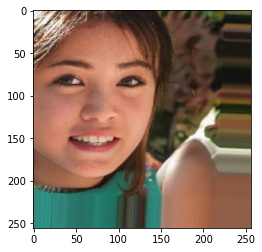

In [ ]:
# посмотрим на размерность и данные которые выдает генератор
train_generator = train_datagen.flow(imgs, batch_size=BATCH_SIZE)
batch = next(train_generator)
print(batch.shape)
print(f'Min: {round(np.min(batch),3)}, Max: {round(np.max(batch),3)}')
print(batch.dtype)
# batch = np.random.random_sample((BATCH_SIZE,*batch.shape[1:]))
x = batch[0]*255 # скалируем картинку обратно для просмотра
plt.imshow(x.astype('uint8'))
plt.show()

In [ ]:
# # сформируем список классов
# classes = ['background'] + ['smile'] # фон + названия классов 
# num_classes = len(classes) # количество классов (включая пустой класс)
# print(classes)

In [ ]:
# Функция создания предобученной модели segmentator
def create_segmentator():
  segmentator = load_model('/content/drive/MyDrive/Сегментация_улыбок.h5', compile = False) # Загрузить модель и веса обученой модели сегментирования
  segmentator.trainable = False # модель предобучена, веса заморозим
  return segmentator

segmentator = create_segmentator()
segmentator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['block1_conv1[0][0]']           
 alization)                     )                                                             

(256, 256, 2)
Min: 0.0, Max: 1.0
float32


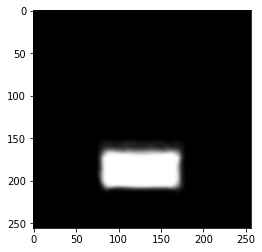

In [ ]:
# проверим работу сегментатора и выход модели
pred = segmentator.predict(imgs[0][None,...])[0]
print(pred.shape)
print(f'Min: {round(np.min(pred),3)}, Max: {round(np.max(pred),3)}')
print(pred.dtype)
plt.imshow(pred[:,:,1]*255, cmap='gray')
plt.show()

In [ ]:
# # попробуем в маски добавить размерность с нулями на axis=3, превращаем тензор (256x256x2)->(256x256x3)
# masks = segmentator.predict(imgs[:BATCH_SIZE])
# print(masks[0].shape)
# masks = np.concatenate((masks, np.zeros((BATCH_SIZE, img_rows, img_cols, 1))), axis=3) # добавим в маски еще один канал, будет (256x256x3) 
# mask = masks[0]
# print(mask.shape)
# plt.imshow(mask[:,:,1]*255, cmap='gray')
# plt.show()

In [ ]:
# Функция создания модели VGG 
def create_vgg():
  vgg_input = Input(img_shape)
  vgg = VGG16(
              weights='imagenet',     # берем предобученную модель
              include_top=False,      # без слоя классификатора
              input_shape=img_shape,  # размерность входного слоя
              input_tensor=vgg_input  # слой на вход в модель
              )
  vgg_out = vgg.get_layer('block5_pool').output 
  vgg = Model(vgg_input, vgg_out, name='VGG')
  vgg.trainable = False # заморозим веса
  return vgg

vgg = create_vgg()
vgg.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "VGG"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                

In [ ]:
# # функция подготовки каналов для модели vgg16 из RGB в BGR и подготовка диапазона значений
# def vgg16_preprocess_img(process_img):
#   x = process_img.copy().astype('float32') # создадим копию
#   x[..., 0] -= 103.939
#   x[..., 1] -= 116.779
#   x[..., 2] -= 123.68
#   x = x[..., ::-1] # меняем каналы RGB->BGR
#   # x = np.clip(x, 0, 255).astype('uint8') 
#   return x

# # функция восстановления каналов после модели vgg16 из BGR в RGB и возврат диапазона значений в стандартные [0..255]
# def vgg16_deprocess_img(processed_img):
#   x = processed_img.copy() # создадим копию
#   x[..., 0] += 103.939
#   x[..., 1] += 116.779
#   x[..., 2] += 123.68
#   x = x[..., ::-1] # меняем каналы BGR->RGB
#   x = np.clip(x, 0, 255).astype('uint8') # подрезать по краям [0..255]
#   return x

In [ ]:
# # взглянем на диапазоны исходных данных, чтобы понимать как скалировать данные
# x0 = imgs
# print(f'Предзагруженные данные: \t\tMin: {round(np.min(x0),3)}, \tMax: {round(np.max(x0),3)}')

# x1 = ((0.5 * x0 + 0.5) * 255).astype('uint8') # скалируем из [-1..1] в [0..255] 
# print(f'Обычный диапазон данных в файле: \tMin: {round(np.min(x1),3)}, \tMax: {round(np.max(x1),3)}')

# x2 = vgg16.preprocess_input(x1) # стандартная функция подготовки данных в vgg модель
# print(f'Стандартная vgg16.preprocess_input: \tMin: {round(np.min(x2),3)}, \tMax: {round(np.max(x2),3)}')

# x3 = vgg16_preprocess_img(x1) # своя функция подготовки данных в vgg модель
# print(f'Своя vgg16_preprocess_img: \t\tMin: {round(np.min(x3),3)}, \tMax: {round(np.max(x3),3)}')

# x4 = vgg16_deprocess_img(x3) # своя функция возврата значений из vgg модели
# print(f'Своя vgg16_deprocess_img: \t\tMin: {round(np.min(x4),3)}, \tMax: {round(np.max(x4),3)}')

# print(x4.shape)

In [ ]:
# # взглянем на выход модели VGG
# n = 100 # сколько сэмплов взять для предикта
# pred = vgg(imgs[:n])
# print(pred.shape)
# pred = pred / 10 
# print(f'VGG данные: \tMin: {round(np.min(pred),3)}, \tMax: {round(np.max(pred),3)}')
# print(np.mean(pred))

##GAN


**Генератор**

In [ ]:
# Функция создания генератора (autoencoder)
def create_generator():
  f = 64 # начальное число фильтров

  # Блок Encoder понижения размерности
  def conv2d(block_input, filters, kernel=3, pooling=True, normalization=True, dropout=0, alpha=0.2): 
    if pooling:
      d = Conv2D(filters, kernel_size=kernel, padding='same')(block_input)  # простой сверточный слой (будем использовать MaxPooling2D)
    else:                                                                   # сверточный слой с понижением разрешения в 2 раза (strides=2, padding='same')
      d = Conv2D(filters, kernel_size=kernel, strides=2, padding='same')(block_input)  
    d = LeakyReLU(alpha=alpha)(d)                                           # активационная функция
    if pooling:
      d = MaxPooling2D()(d)                                                 # понижаем разрешение в 2 раза (MaxPooling2D)
    if normalization:
        d = BatchNormalization(momentum=0.8)(d)                             # слой нормализации                           
    if dropout:                                                             
      d = Dropout(dropout)(d)                                               # слой регуляризации
    return d

  # Блок Decoder повышения размерности (принимает на вход блоки из Encoder)
  def deconv2d(block_input, second_input, filters, kernel=3, transpose=True, normalization=True, dropout=0, alpha=0.2):
    if transpose:
      u = Conv2DTranspose(filters, 2, strides=2, padding='same')(block_input)   # увеличивам разрешение в 2 раза (Conv2DTranspose)
    else:
      u = UpSampling2D(size=2)(block_input)                                     # увеличивам разрешение в 2 раза (UpSampling)
      u = Conv2D(filters, kernel_size=kernel, padding='same')(u)
    u = LeakyReLU(alpha=alpha)(u)                                               # активационная функция
    if normalization:
      u = BatchNormalization(momentum=0.8)(u)                                   # слой нормализации                           
    if dropout:                                                                 
      u = Dropout(dropout)(u)                                                   # слой регуляризации
    u = concatenate([u, second_input])                                                # сложение со слоем уровня Encoder
    return u

  img_input = Input(shape=img_shape, name='condition')  # входное изображение-условие (256x256x3)

  # Encoder
  out_img_1 = conv2d(img_input, f)    # (256 x 256 x 64)  -> (128 x 128 x 64) 

  out_img_2 = conv2d(out_img_1, f*2)  # (128 x 128 x 128) -> (64 x 64 x 128)

  out_img_3 = conv2d(out_img_2, f*4)  # (64 x 64 x 256)   -> (32 x 32 x 256)

  out_img_4 = conv2d(out_img_3, f*8)  # (32 x 32 x 512)   -> (16 x 16 x 512)

  out_img_5 = conv2d(out_img_4, f*8)  # (16 x 16 x 512)   -> (8 x 8 x 512)
  
  out_img_6 = conv2d(out_img_5, f*8)  # (8 x 8 x 512)     -> (4 x 4 x 512) 

  # Decoder
  out_up_6 = deconv2d(out_img_6, out_img_5, f*8)  # (4 x 4 x 512)   -> (8 x 8 x 512)

  out_up_5 = deconv2d(out_up_6, out_img_4, f*8)  # (8 x 8 x 512)   -> (16 x 16 x 512)

  out_up_4 = deconv2d(out_up_5, out_img_3, f*8)  # (16 x 16 x 512) -> (32 x 32 x 512)

  out_up_3 = deconv2d(out_up_4, out_img_2, f*4)  # (32 x 32 x 256) -> (64 x 64 x 256)

  out_up_2 = deconv2d(out_up_3, out_img_1, f*2)  # (64 x 64 x 128) -> (128 x 128 x 128)

  out_up_1 = Conv2DTranspose(f, 2, strides=2, padding='same')(out_up_2) # (128 x 128 x 128) -> (256 x 256 x 64)
  # out_up_1 = UpSampling2D(size=2)(out_up_2) # (128 x 128 x 128) -> (256 x 256 x 128)

  out_up_1 = LeakyReLU(alpha=0.2)(out_up_1) # активационная функция
  out_up_1 = BatchNormalization()(out_up_1) # слой нормализации

  img_output = Conv2D(3, kernel_size=1, padding='same', activation='sigmoid', name='G_output')(out_up_1) # выход в диапазоне [0..1] как у входного изображения, используем sigmoid

  generator = Model(img_input, img_output, name='G')

  return generator

Model: "G"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 condition (InputLayer)         [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['condition[0][0]']              
                                )                                                                 
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 256, 256, 64  0           ['conv2d[0][0]']                 
                                )                                                                 

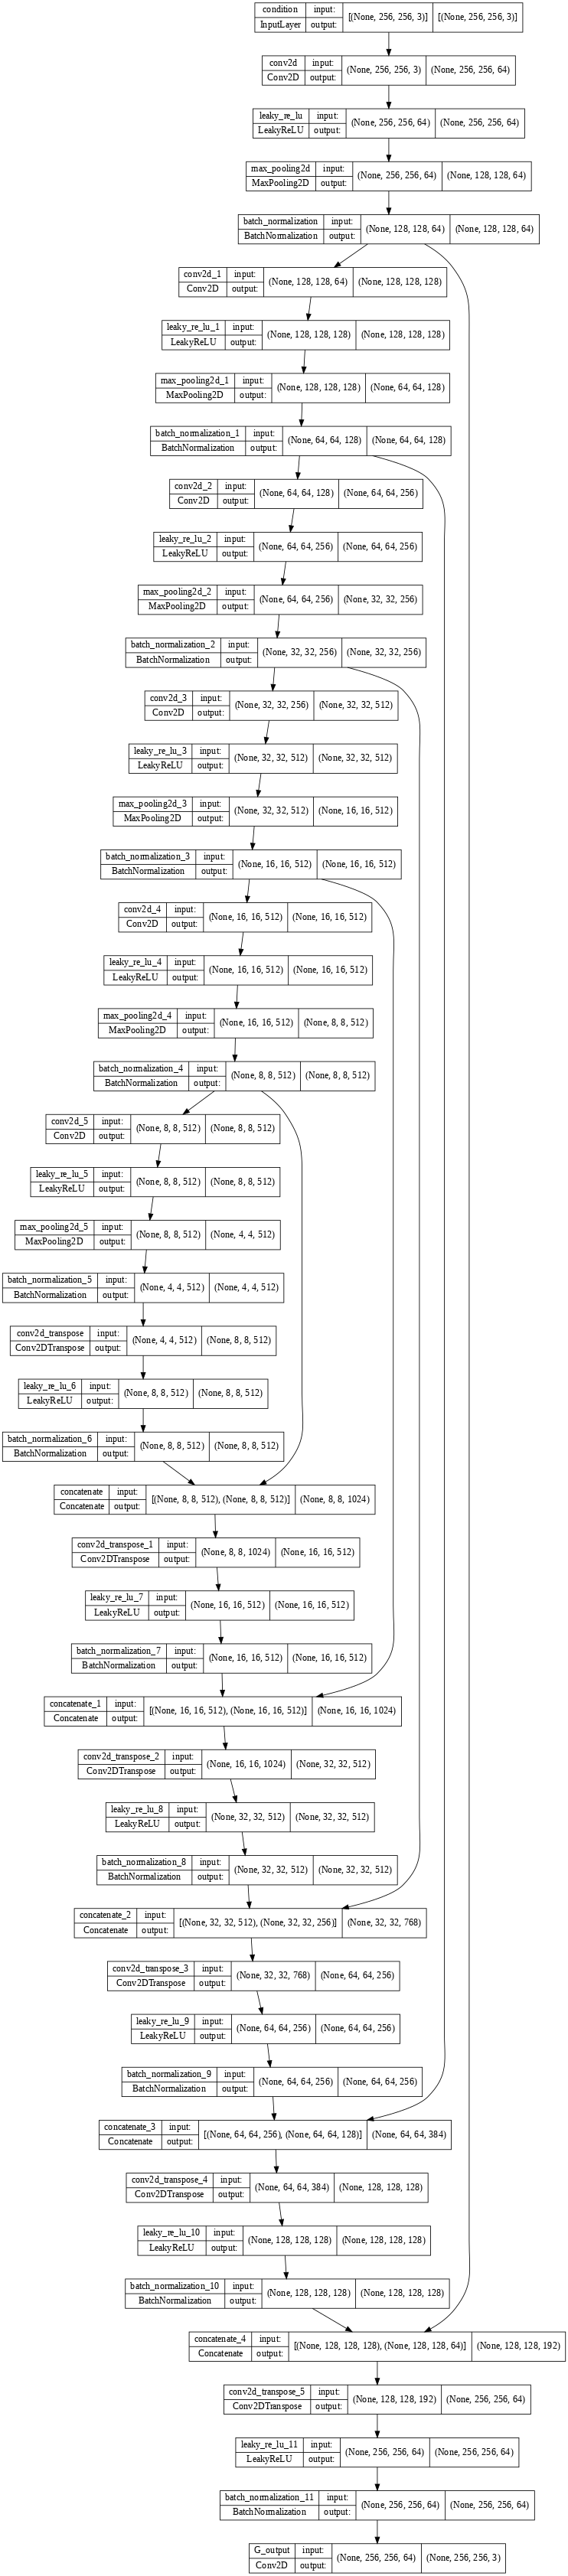

In [ ]:
# создаем генератор
generator = create_generator()
generator.summary()
utils.plot_model(generator, dpi=60, show_shapes=True) # схема модели

**Дискриминатор**

In [ ]:
# Функция создания дискриминатора
def create_discriminator():
  f = 64 # начальное число фильтров

  # Блок понижения размерности
  def conv2d(block_input, filters, kernel=3, pooling=True, normalization=True, dropout=0, alpha=0.2): 
    if pooling:
      d = Conv2D(filters, kernel_size=kernel, padding='same')(block_input)  # простой сверточный слой (будем использовать MaxPooling2D)
    else:                                                                   # сверточный слой с понижением разрешения в 2 раза (strides=2, padding='same')
      d = Conv2D(filters, kernel_size=kernel, strides=2, padding='same')(block_input)  
    d = LeakyReLU(alpha=alpha)(d)                                           # активационная функция
    if normalization:
        d = BatchNormalization(momentum=0.8)(d)                             # слой нормализации                           

    d = Conv2D(filters, kernel_size=kernel, padding='same')(d)              # простой сверточный слой
    d = LeakyReLU(alpha=alpha)(d)                                           # активационная функция
    if normalization:
        d = BatchNormalization(momentum=0.8)(d)                             # слой нормализации                           

    # d = Conv2D(filters, kernel_size=kernel, padding='same')(d)              # простой сверточный слой
    # d = LeakyReLU(alpha=alpha)(d)                                           # активационная функция
    # if normalization:
    #     d = BatchNormalization(momentum=0.8)(d)                             # слой нормализации                           

    if pooling:
      d = MaxPooling2D()(d)                                                 # понижаем разрешение в 2 раза (MaxPooling2D)
    if normalization:
        d = BatchNormalization(momentum=0.8)(d)                             # слой нормализации                           
    if dropout:                                                             
      d = Dropout(dropout)(d)                                               # слой регуляризации
    return d
  
  condition = Input(shape=img_shape, name='condition')  # изображение(условие) в полный размер исходное
  gen_input = Input(shape=img_shape, name='gen_image')  # изображение(сгенерированое) в полный размер от генератора 

  combined_imgs = concatenate([condition, gen_input]) # объединяем по каналам оба изображения

  # понижаем размерности размерности
  d1 = conv2d(combined_imgs, f) # (256 x 256 x 64)  -> (128 x 128 x 64) 
  d2 = conv2d(d1, f*2)          # (128 x 128 x 128) -> (64 x 64 x 128)
  d3 = conv2d(d2, f*4)          # (64 x 64 x 256)   -> (32 x 32 x 256)
  d4 = conv2d(d3, f*8)          # (32 x 32 x 512)   -> (16 x 16 x 512)
  d5 = conv2d(d4, f*8)          # (16 x 16 x 512)   -> (8 x 8 x 512)

  # техника patch GAN: двумерный массив, каждый элемент которого определяет, подлинность части изображения
  # 0 отвечает за фейковые изображения, 1 за подлинные, поэтому используем sigmoid
  validity = Conv2D(1, kernel_size=3, padding='same', activation='sigmoid', name='D_output')(d5)

  discriminator = Model([condition, gen_input], validity, name='D')

  # можно скомпилировать здесь или вместе с GAN перед началом обучения
  #discriminator.compile(loss='binary_crossentropy', optimizer=OPTIMIZER, metrics=['mae']) # binary_crossentropy потому что используем технику "patch GAN"

  return discriminator

Model: "D"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 condition (InputLayer)         [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 gen_image (InputLayer)         [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_5 (Concatenate)    (None, 256, 256, 6)  0           ['condition[0][0]',              
                                                                  'gen_image[0][0]']              

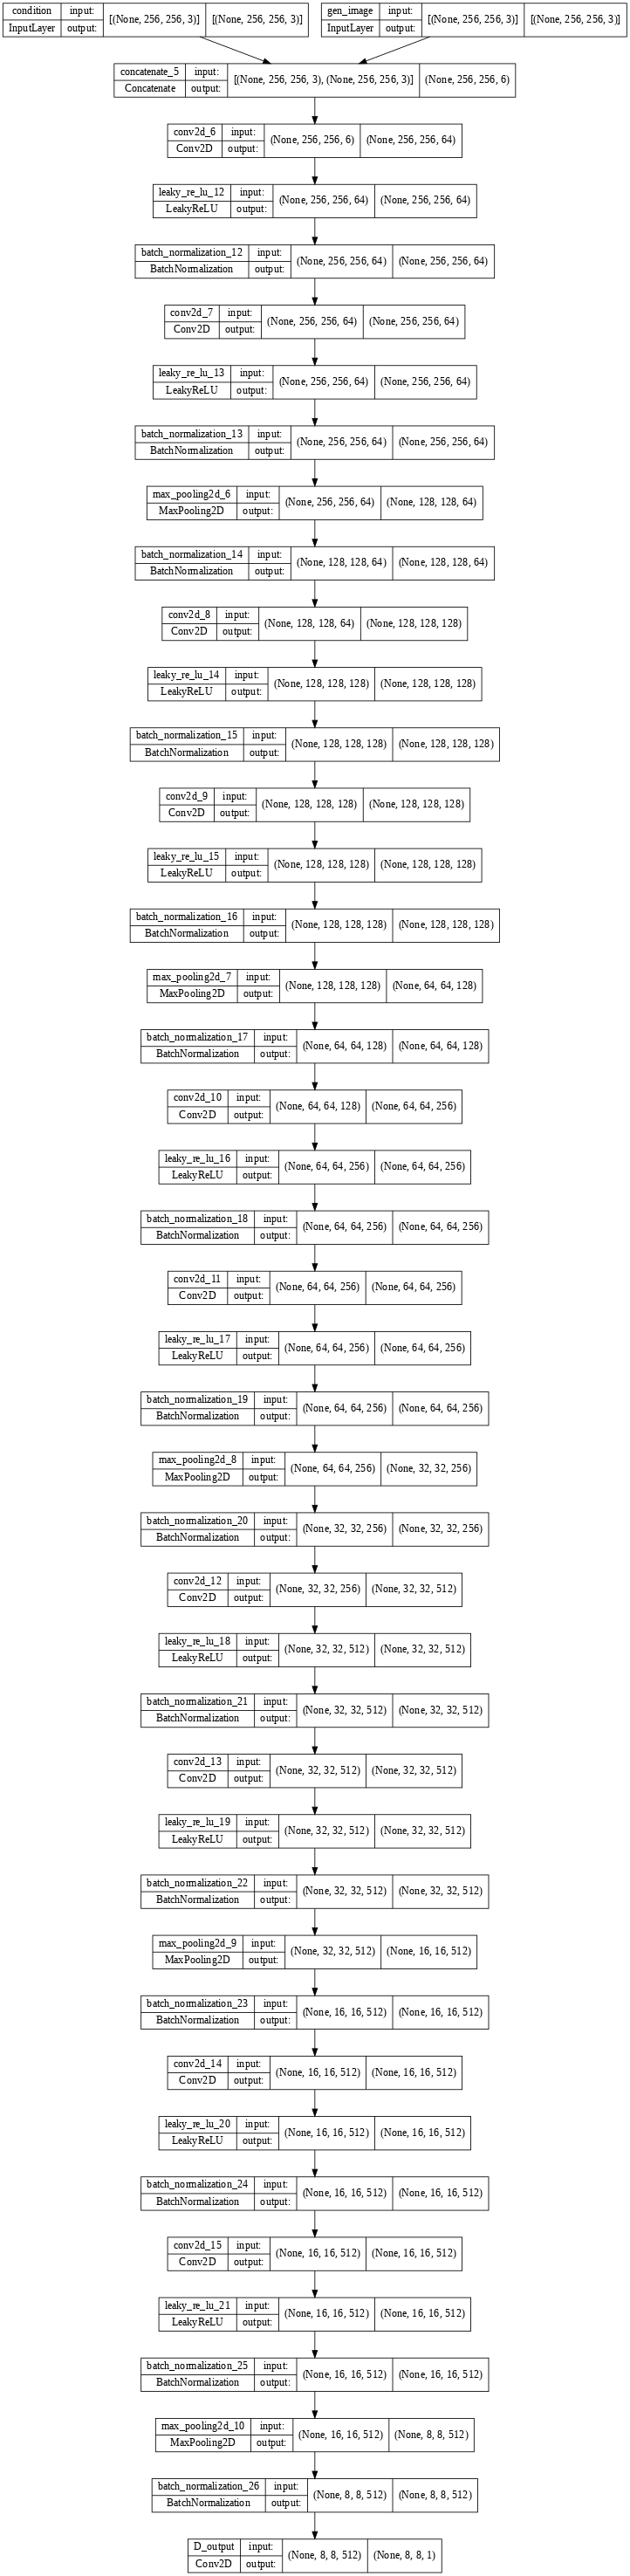

In [ ]:
# создаем дискриминатор
discriminator = create_discriminator()
discriminator.summary()
utils.plot_model(discriminator, dpi=60, show_shapes=True) # схема модели

In [ ]:
# Функция создания сети GAN
def create_gan(generator, discriminator, vgg):
  discriminator.trainable = False # замораживаем веса дискриминатора (обучение только отдельно, в составе GAN обучается только генератор)

  condition = Input(img_shape, name='condition')    # изображение-маска в полный размер

  gen_output = generator(condition)                 # прогоняем изображение+маску через генератор

  gen_features = vgg(gen_output)                    # собираем фичи в малой размерности от сгенерированного генератором

  validity = discriminator([condition, gen_output]) # соединяем генератор и дискриминатор

  # получаем GAN с тремя выходами: первый-правдоподобность, второй-изображение от генератора, третий-фичи от генератора
  gan = Model(condition, [validity, gen_output, gen_features], name='GAN')

  gan.compile(loss=['binary_crossentropy', 'mse', 'mse'], # Компилируем модель, используя несколько loss'ов
              loss_weights=[1,100,10], # вес каждого loss в общей модели GAN
              optimizer=OPTIMIZER)

  return gan

In [ ]:
# размерность выхода дискриминатора без батча
discriminator.output.shape[1:]

TensorShape([8, 8, 1])

In [ ]:
# пример генерации тензора с "единицами" для target
np.ones( (128, *discriminator.output_shape[1:]) ).shape

(128, 8, 8, 1)

In [ ]:
# выход моделей (для понимания loss'ов моделей)

import math
def sigmoid(x): # функция сигмоиды (sigmoid)
  return 1 / (1 + math.exp(-x))

print('Сигмоида для вероятности 0.5 =', sigmoid(.5))
print('BinaryCrossentropy для вероятности 0.5 =', -math.log(.5))

Сигмоида для вероятности 0.5 = 0.6224593312018546
BinaryCrossentropy для вероятности 0.5 = 0.6931471805599453


In [ ]:
# попробуем собрать композитную модель
generator = create_generator() # создаем генератор
discriminator = create_discriminator() # создаем дискриминатор
discriminator.compile(loss='binary_crossentropy', optimizer=OPTIMIZER, metrics=['mae'])
vgg = create_vgg()                  # создаем vgg модель
segmentator = create_segmentator()  # создаем сегментатор
gan = create_gan(generator, discriminator, vgg) # создаем cgan
# loss_weights - соотв. выход gan на соотв. число: вклад разницы между пикселями в 10 раз больше, чем вклад от feature loss и в 100 раз больше, чем вклад от GAN
gan.compile(loss=['binary_crossentropy', 'mse', 'mse'], loss_weights=[1,100,10], optimizer=OPTIMIZER)

real_imgs = next( train_datagen.flow(imgs, batch_size=BATCH_SIZE) )
y_real = np.ones((BATCH_SIZE, *discriminator.output_shape[1:]))
real_features = vgg.predict(real_imgs)

d_loss_real = discriminator.train_on_batch([real_imgs, real_imgs], y_real)
g_loss = gan.train_on_batch(real_imgs, [y_real, real_imgs, real_features])

# смотрим, что нам возвращает метод model.train_on_batch
# запускать после первого вызова train_on_batch, иначе будут пустые списки
print(discriminator.metrics_names)
print(gan.metrics_names)

['loss', 'mae']
['loss', 'D_loss', 'G_loss', 'VGG_loss']


In [ ]:
# Функция демонстрации результата обучения
def sample_images(filename='/content/drive/MyDrive/hank.jpg', epoch=0):
  fig, axs = plt.subplots(1, 3, figsize=(15, 5)) #Создаем полотно из 3 графиков
  img = np.array( image.load_img(filename, target_size=(img_rows,img_cols)), dtype='uint8' ) # загружаем файл
  axs[0].imshow(img)
  axs[0].set_xlabel(f'Оригинал')
  img = img.astype('float32')/255 # переведем из диапазона [0..255] в диапазон [0..1] для моделей
  # img = imgs[0]
  img = img[None,...] # добавить размерность для предикта
  segment = segmentator.predict(img) # сегментируем
  condition = erase_segment(img, segment) # получим "изображение-условие" для подачи модели
  segment_unscaled = (segment[0]*255).astype('uint8') # переводим из диапазона [0..1] в диапазон [0..255] для вывода картинки
  axs[1].imshow(segment_unscaled[:,:,1], cmap='gray')
  axs[1].set_xlabel(f'Маска')
  # plt.show()
  # segment = np.concatenate((segment, np.zeros((1, img_rows, img_cols, 1))), axis=3) # добавим еще один канал, превращаем тензор (256x256x2)->(256x256x3) 
  pred = generator.predict(condition)[0]
  pred_unscaled = (pred*255).astype('uint8') # переводим из диапазона [0..1] в диапазон [0..255] для вывода картинки
  axs[2].imshow(pred_unscaled)
  axs[2].set_xlabel(f'Улыбка')
  if epoch>0:
    plt.savefig('image'+str(epoch)+'.jpg') # сохранить графики в файл
  plt.show()

# Функция сохранения моделей
def save_models():
  model_path = '/content/drive/MyDrive/'
  # generator.save(model_path + 'generator.h5')
  generator.save_weights(model_path + 'generator_weights.h5') # модель генератора
  # discriminator.save(model_path + 'discriminator.h5')
  discriminator.save_weights(model_path + 'discriminator_weights.h5') # модель дискриминатора

# Функция сохранения моделей
def load_models():
  model_path = '/content/drive/MyDrive/'
  # generator.save(model_path + 'generator.h5')
  generator.load_weights(model_path + 'generator_weights.h5') # модель генератора
  # discriminator.save(model_path + 'discriminator.h5')
  discriminator.load_weights(model_path + 'discriminator_weights.h5') # модель дискриминатора

# Функция удаления указанного сегмента с картинки
def erase_segment(i, s): # i-исходная картинка, s-сегментированная картинка
  out = copy.deepcopy(i) # копируем тензор со всеми вложенными элементами
  out[...,0][s[...,1]>0.5] = 0 # пишем нули в R канал
  out[...,1][s[...,1]>0.5] = 0 # пишем нули в G канал
  out[...,2][s[...,1]>0.5] = 0 # пишем нули в B канал
  return out

In [ ]:
# Функция обучения GAN
def train(epochs, batch_size):

  epoch_interval = 1 # Указываем интервал эпох, через который будем выводить текущие результаты обучения
  
  # ['loss', 'mae']
  # ['loss', 'D_loss', 'G_loss', 'VGG_loss']
  d_loss_list       = [] # Массив значений ошибки дискриминатора
  d_acc_list        = [] # Массив значений точности модели дискриминатора
  gan_loss_list     = [] # Массив значений ошибки модели GAN
  d_lossBC_list     = [] # Массив значений ошибки дискриминатора BinaryCrossentropy
  g_lossMSE_list    = [] # Массив значений ошибки генератора MSE
  vgg_lossMSE_list  = [] # Массив значений ошибки VGG MSE

  for epoch in range(epochs): 
    print(f'Epoch {epoch+1}:')

    batches = 0 # считаем батчи чтобы остановить эпоху при превышении

    for real_imgs in train_datagen.flow(imgs, batch_size=batch_size):
      
      #для тренировки дискриминатора применяем label smoothing
      #размерность Y: (размер батча, высота последнего слоя дискриминатора, ширина, 1)
      y_real = np.ones((batch_size, *discriminator.output_shape[1:])) - np.random.random_sample((batch_size, *discriminator.output_shape[1:]))*0.2
      y_fake = np.random.random_sample((batch_size, *discriminator.output_shape[1:]))*0.2

      seg_imgs = segmentator.predict(real_imgs) # получим сегментированные изображения из исходных
      # seg_imgs = np.concatenate((seg_imgs, np.zeros((batch_size, img_rows, img_cols, 1))), axis=3) # добавим в маски еще один канал, превращаем тензор (256x256x2)->(256x256x3) 

      conditions = erase_segment(real_imgs, seg_imgs) # "изображения-условия" (удалим с исходных картинок сегментированную часть записав в эти области "нули")
      
      gen_imgs = generator.predict(conditions) # генерируем изображения по "изображениям-условия" с удаленными фрагментами сегментов

      #тренируем дискриминатор       
      d_loss_real = discriminator.train_on_batch([conditions, real_imgs], y_real) # получаем loss от сравнения "изображения-условия" + исходные с "единицами"
      d_loss_fake = discriminator.train_on_batch([conditions, gen_imgs], y_fake)  # получаем loss от сравнения "изображения-условия" + сгенерированные с "нулями"
      d_loss      = 0.5*np.add(d_loss_real, d_loss_fake)                          # считаем общий loss дискриминатора

      #тренируем генератор
      real_features = vgg.predict(real_imgs) # получим фичи от real_imgs (от исходных картинок)

      y_real = np.ones((batch_size, *discriminator.output_shape[1:])) # получим эталонные "единицы" еще раз для генератора

      g_loss = gan.train_on_batch(conditions, [y_real, real_imgs, real_features])

      # вывод номер батча и значения ошибок на этом батче
      print ('[Batch: %d/%d] [D_loss: %f, D_acc: %f] [GAN_loss: %f, D_lossBC: %f, G_lossMSE: %f, VGG_lossMSE: %f]' % \
             (batches+1, imgs.shape[0]//batch_size, d_loss[0], d_loss[1], g_loss[0], g_loss[1], g_loss[2], g_loss[3]))

      d_loss_list.append(d_loss[0])       # Добавляем в маcсив значений ошибки дискриминатора
      d_acc_list.append(100*d_loss[1])    # Добавляем в маcсив значений точности модели дискриминатора
      gan_loss_list.append(g_loss[0])     # Добавляем в маcсив значений ошибки модели GAN
      d_lossBC_list.append(g_loss[1])     # Добавляем в маcсив значений ошибки дискриминатора BinaryCrossentropy
      g_lossMSE_list.append(g_loss[2])    # Добавляем в маcсив значений ошибки генератора MSE
      vgg_lossMSE_list.append(g_loss[3])  # Добавляем в маcсив значений ошибки VGG MSE

      batches += 1
      # прерываем текущую эпоху если обработали все сэмплы, т.к. генератор работает в бесконечном цикле  
      if batches >= (imgs.shape[0] // batch_size):
        break

    # Проверяем на условие вывода информации раз в epoch_interval эпох
    if ( (epoch % epoch_interval == 0) or (epoch == epochs-1) ):
      sample_images() # Вызываем функцию sample_images для печати изображений
      save_models() # сохраним веса 
      global last_epoch
      last_epoch = epoch # сохраним последнюю эпоху обучения для сборки gif


  # Выводим графики
  fig, axs = plt.subplots(1, 3, figsize=(15, 5)) #Создаем полотно из 3 графиков
  axs[0].plot(d_lossBC_list, label='Ошибка BinaryCrossentropy генератора')
  axs[0].plot(d_loss_list, label='Ошибка BinaryCrossentropy дискриминатора')
  # plt.legend()
  # plt.show()
  axs[1].plot(gan_loss_list, label='Общая ошибка генератора')
  axs[1].plot(100*g_lossMSE_list, label='Ошибка MSE генератора * 100')
  axs[1].plot(100*vgg_lossMSE_list, label='Ошибка MSE VGG * 100')
  # plt.legend()
  # plt.show()
  axs[2].plot(d_acc_list, label='Точность дискриминатора')
  plt.legend()
  plt.show()

  # сохраним графики
  # переведем массивы в numpy
  d_loss_list       = np.array(d_loss_list, dtype='float32') # Массив значений ошибки дискриминатора
  d_acc_list        = np.array(d_acc_list, dtype='float32') # Массив значений точности модели дискриминатора
  gan_loss_list     = np.array(gan_loss_list, dtype='float32') # Массив значений ошибки модели GAN
  d_lossBC_list     = np.array(d_lossBC_list, dtype='float32') # Массив значений ошибки дискриминатора BinaryCrossentropy
  g_lossMSE_list    = np.array(g_lossMSE_list, dtype='float32') # Массив значений ошибки генератора MSE
  vgg_lossMSE_list  = np.array(vgg_lossMSE_list, dtype='float32') # Массив значений ошибки VGG MSE
  #  сохраним графики в numpy массивах
  np.save('/content/drive/MyDrive/d_loss_list.npy', d_loss_list)
  np.save('/content/drive/MyDrive/d_acc_list.npy', d_acc_list)
  np.save('/content/drive/MyDrive/gan_loss_list.npy', gan_loss_list)
  np.save('/content/drive/MyDrive/d_lossBC_list.npy', d_lossBC_list)
  np.save('/content/drive/MyDrive/g_lossMSE_list.npy', g_lossMSE_list)
  np.save('/content/drive/MyDrive/vgg_lossMSE_list.npy', vgg_lossMSE_list)  

In [ ]:
import gc    
gc.collect() # очистка памяти

generator     = create_generator()      # создаем генератор
discriminator = create_discriminator()  # создаем дискриминатор
vgg           = create_vgg()            # создаем vgg модель
segmentator   = create_segmentator()    # создаем сегментатор
gan           = create_gan(generator, discriminator, vgg) # создаем gan

In [ ]:
# train(1, 16) # тренируем модель

In [ ]:
# save_models()
# load_models()

In [ ]:
import gc    
gc.collect() # очистка памяти

BATCH_SIZE    = 16                          # размер батча
OPTIMIZER     = Adam(learning_rate=1e-4, beta_1=0.5)   # оптимайзер
EPOCHS        = 100                          # количество эпох

# разрешение дискриминатору обучаться в качестве отдельной модели
discriminator.trainable = True
discriminator.compile(loss='binary_crossentropy', # binary_crossentropy в дискриминаторе потому что используем технику "patch GAN"
                      optimizer=OPTIMIZER,
                      metrics=['mae'])
# запрет на обучение в составе комбинированной модели CGAN
discriminator.trainable = False
# loss_weights - соотв. выход gan на соотв. число: весовой вклад от: GAN, попиксельно real_imgs, feature_loss 
gan.compile(loss=['binary_crossentropy', 'mse', 'mse'],
            loss_weights=[1,100,10],
            optimizer=OPTIMIZER)

train(EPOCHS, BATCH_SIZE) # тренируем модель


In [ ]:
# save_models()
load_models()

In [ ]:
# ДООБУЧАЕМ

import gc    
gc.collect() # очистка памяти

BATCH_SIZE    = 16                          # размер батча
OPTIMIZER     = Adam(learning_rate=1e-6, beta_1=0.5)   # оптимайзер
EPOCHS        = 200                          # количество эпох

# разрешение дискриминатору обучаться в качестве отдельной модели
discriminator.trainable = True
discriminator.compile(loss='binary_crossentropy', # binary_crossentropy в дискриминаторе потому что используем технику "patch GAN"
                      optimizer=OPTIMIZER,
                      metrics=['mae'])
# запрет на обучение в составе комбинированной модели CGAN
discriminator.trainable = False
# loss_weights - соотв. выход gan на соотв. число: весовой вклад от: GAN, попиксельно real_imgs, feature_loss 
gan.compile(loss=['binary_crossentropy', 'mse', 'mse'],
            loss_weights=[1,100,10],
            optimizer=OPTIMIZER)

train(EPOCHS, BATCH_SIZE) # тренируем модель

In [ ]:
import imageio # библиотека imageio
images = [] # пустой лист для картинок в gif

for i in range(last_epoch): # берем каждый фрейм
    images.append(imageio.imread('image'+str(i)+'.jpg')) # добавляем в список
imageio.mimsave('SmilerV6.gif', images) # .mimsave() сохраняет в gif

In [ ]:
# Функция расчета веса моделим в памяти с учетом размера batch_size
def get_model_memory_usage(batch_size, model):
    import numpy as np
    try:
        from keras import backend as K
    except:
        from tensorflow.keras import backend as K

    shapes_mem_count = 0
    internal_model_mem_count = 0
    for l in model.layers:
        layer_type = l.__class__.__name__
        if layer_type == 'Model':
            internal_model_mem_count += get_model_memory_usage(batch_size, l)
        single_layer_mem = 1
        out_shape = l.output_shape
        if type(out_shape) is list:
            out_shape = out_shape[0]
        for s in out_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = np.sum([K.count_params(p) for p in model.trainable_weights])
    non_trainable_count = np.sum([K.count_params(p) for p in model.non_trainable_weights])

    number_size = 4.0
    if K.floatx() == 'float16':
        number_size = 2.0
    if K.floatx() == 'float64':
        number_size = 8.0

    total_memory = number_size * (batch_size * shapes_mem_count + trainable_count + non_trainable_count)
    gbytes = np.round(total_memory / (1024.0 ** 3), 3) + internal_model_mem_count
    return gbytes

print(f'Занимаемый моделями объем памяти (batch_size={BATCH_SIZE}):')
print('GAN:\t\t', get_model_memory_usage(BATCH_SIZE, gan), 'Gbytes')
print('generator:\t', get_model_memory_usage(BATCH_SIZE, generator), 'Gbytes')
print('discriminator:\t', get_model_memory_usage(BATCH_SIZE, discriminator), 'Gbytes')
print('segmentator:\t', get_model_memory_usage(BATCH_SIZE, segmentator), 'Gbytes')
print('VGG:\t\t', get_model_memory_usage(BATCH_SIZE, vgg), 'Gbytes')

Занимаемый моделями объем памяти (batch_size=16):
GAN:		 0.162 Gbytes
generator:	 3.05 Gbytes
discriminator:	 3.18 Gbytes
segmentator:	 5.721 Gbytes
VGG:		 1.24 Gbytes
